In [5]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
from nba_api.stats.endpoints.leaguedashplayershotlocations import LeagueDashPlayerShotLocations
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats


In [9]:
stats_df = LeagueDashPlayerStats(season='2023-24', per_mode_detailed='PerGame').get_data_frames()[0]

In [2]:
shot_df = LeagueDashPlayerShotLocations(distance_range='8ft Range', per_mode_detailed='PerGame').get_data_frames()[0]

In [21]:
subset = stats_df.loc[:, ['PLAYER_ID', 'PLAYER_NAME', 'GP', 'MIN']]

In [22]:
subset.columns = pd.MultiIndex.from_arrays([[''] * len(subset.columns), subset.columns])

In [23]:
subset.columns

MultiIndex([('',   'PLAYER_ID'),
            ('', 'PLAYER_NAME'),
            ('',          'GP'),
            ('',         'MIN')],
           )

In [25]:
merged_df = pd.merge(left=subset, right=shot_df, on=[('', 'PLAYER_ID'), ('', 'PLAYER_NAME')])

In [28]:
filtered_merged = merged_df.loc[(merged_df[('', 'GP')] > 10) & (merged_df[('', 'MIN')] > 20)]

In [29]:
filtered_merged.columns

MultiIndex([(               '',         'PLAYER_ID'),
            (               '',       'PLAYER_NAME'),
            (               '',                'GP'),
            (               '',               'MIN'),
            (               '',           'TEAM_ID'),
            (               '', 'TEAM_ABBREVIATION'),
            (               '',               'AGE'),
            (               '',          'NICKNAME'),
            ('Less Than 8 ft.',               'FGM'),
            ('Less Than 8 ft.',               'FGA'),
            ('Less Than 8 ft.',            'FG_PCT'),
            (       '8-16 ft.',               'FGM'),
            (       '8-16 ft.',               'FGA'),
            (       '8-16 ft.',            'FG_PCT'),
            (      '16-24 ft.',               'FGM'),
            (      '16-24 ft.',               'FGA'),
            (      '16-24 ft.',            'FG_PCT'),
            (        '24+ ft.',               'FGM'),
            (        '24+ ft

In [32]:
top_mid_range = filtered_merged.sort_values(by=('8-16 ft.','FGA'), ascending=False).iloc[:30]

In [37]:
top_mid_range.loc[:, (       '8-16 ft.',            'FG_PCT')] = top_mid_range[(       '8-16 ft.',            'FG_PCT')] * 100

In [40]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
def getImage(path, zoom=1.0):
    #print(path)
    return OffsetImage(plt.imread(path), zoom=zoom)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter


import matplotlib.ticker as mtick

zoom = 0.65
team_root_dir = '../../team_logos_id/'
player_root_dir = 'player_imgs/'

def get_player_img(player_id, should_download=False, zoom=zoom):
    path = Path(f'player_imgs/{player_id}.png').absolute()
    if path.exists():
        return
    if should_download:
        url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
        response = requests.get(url)
        img = plt.imread(BytesIO(response.content))
        with open(f'player_imgs/{player_id}.png', 'wb') as f:
            f.write(response.content)
    else:
        img = plt.imread(f'{player_root_dir}{player_id}.png')
    #print(path)
    return OffsetImage(img, zoom=zoom)

def get_team_img(team_id):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

In [43]:
plt.style.use('fivethirtyeight')

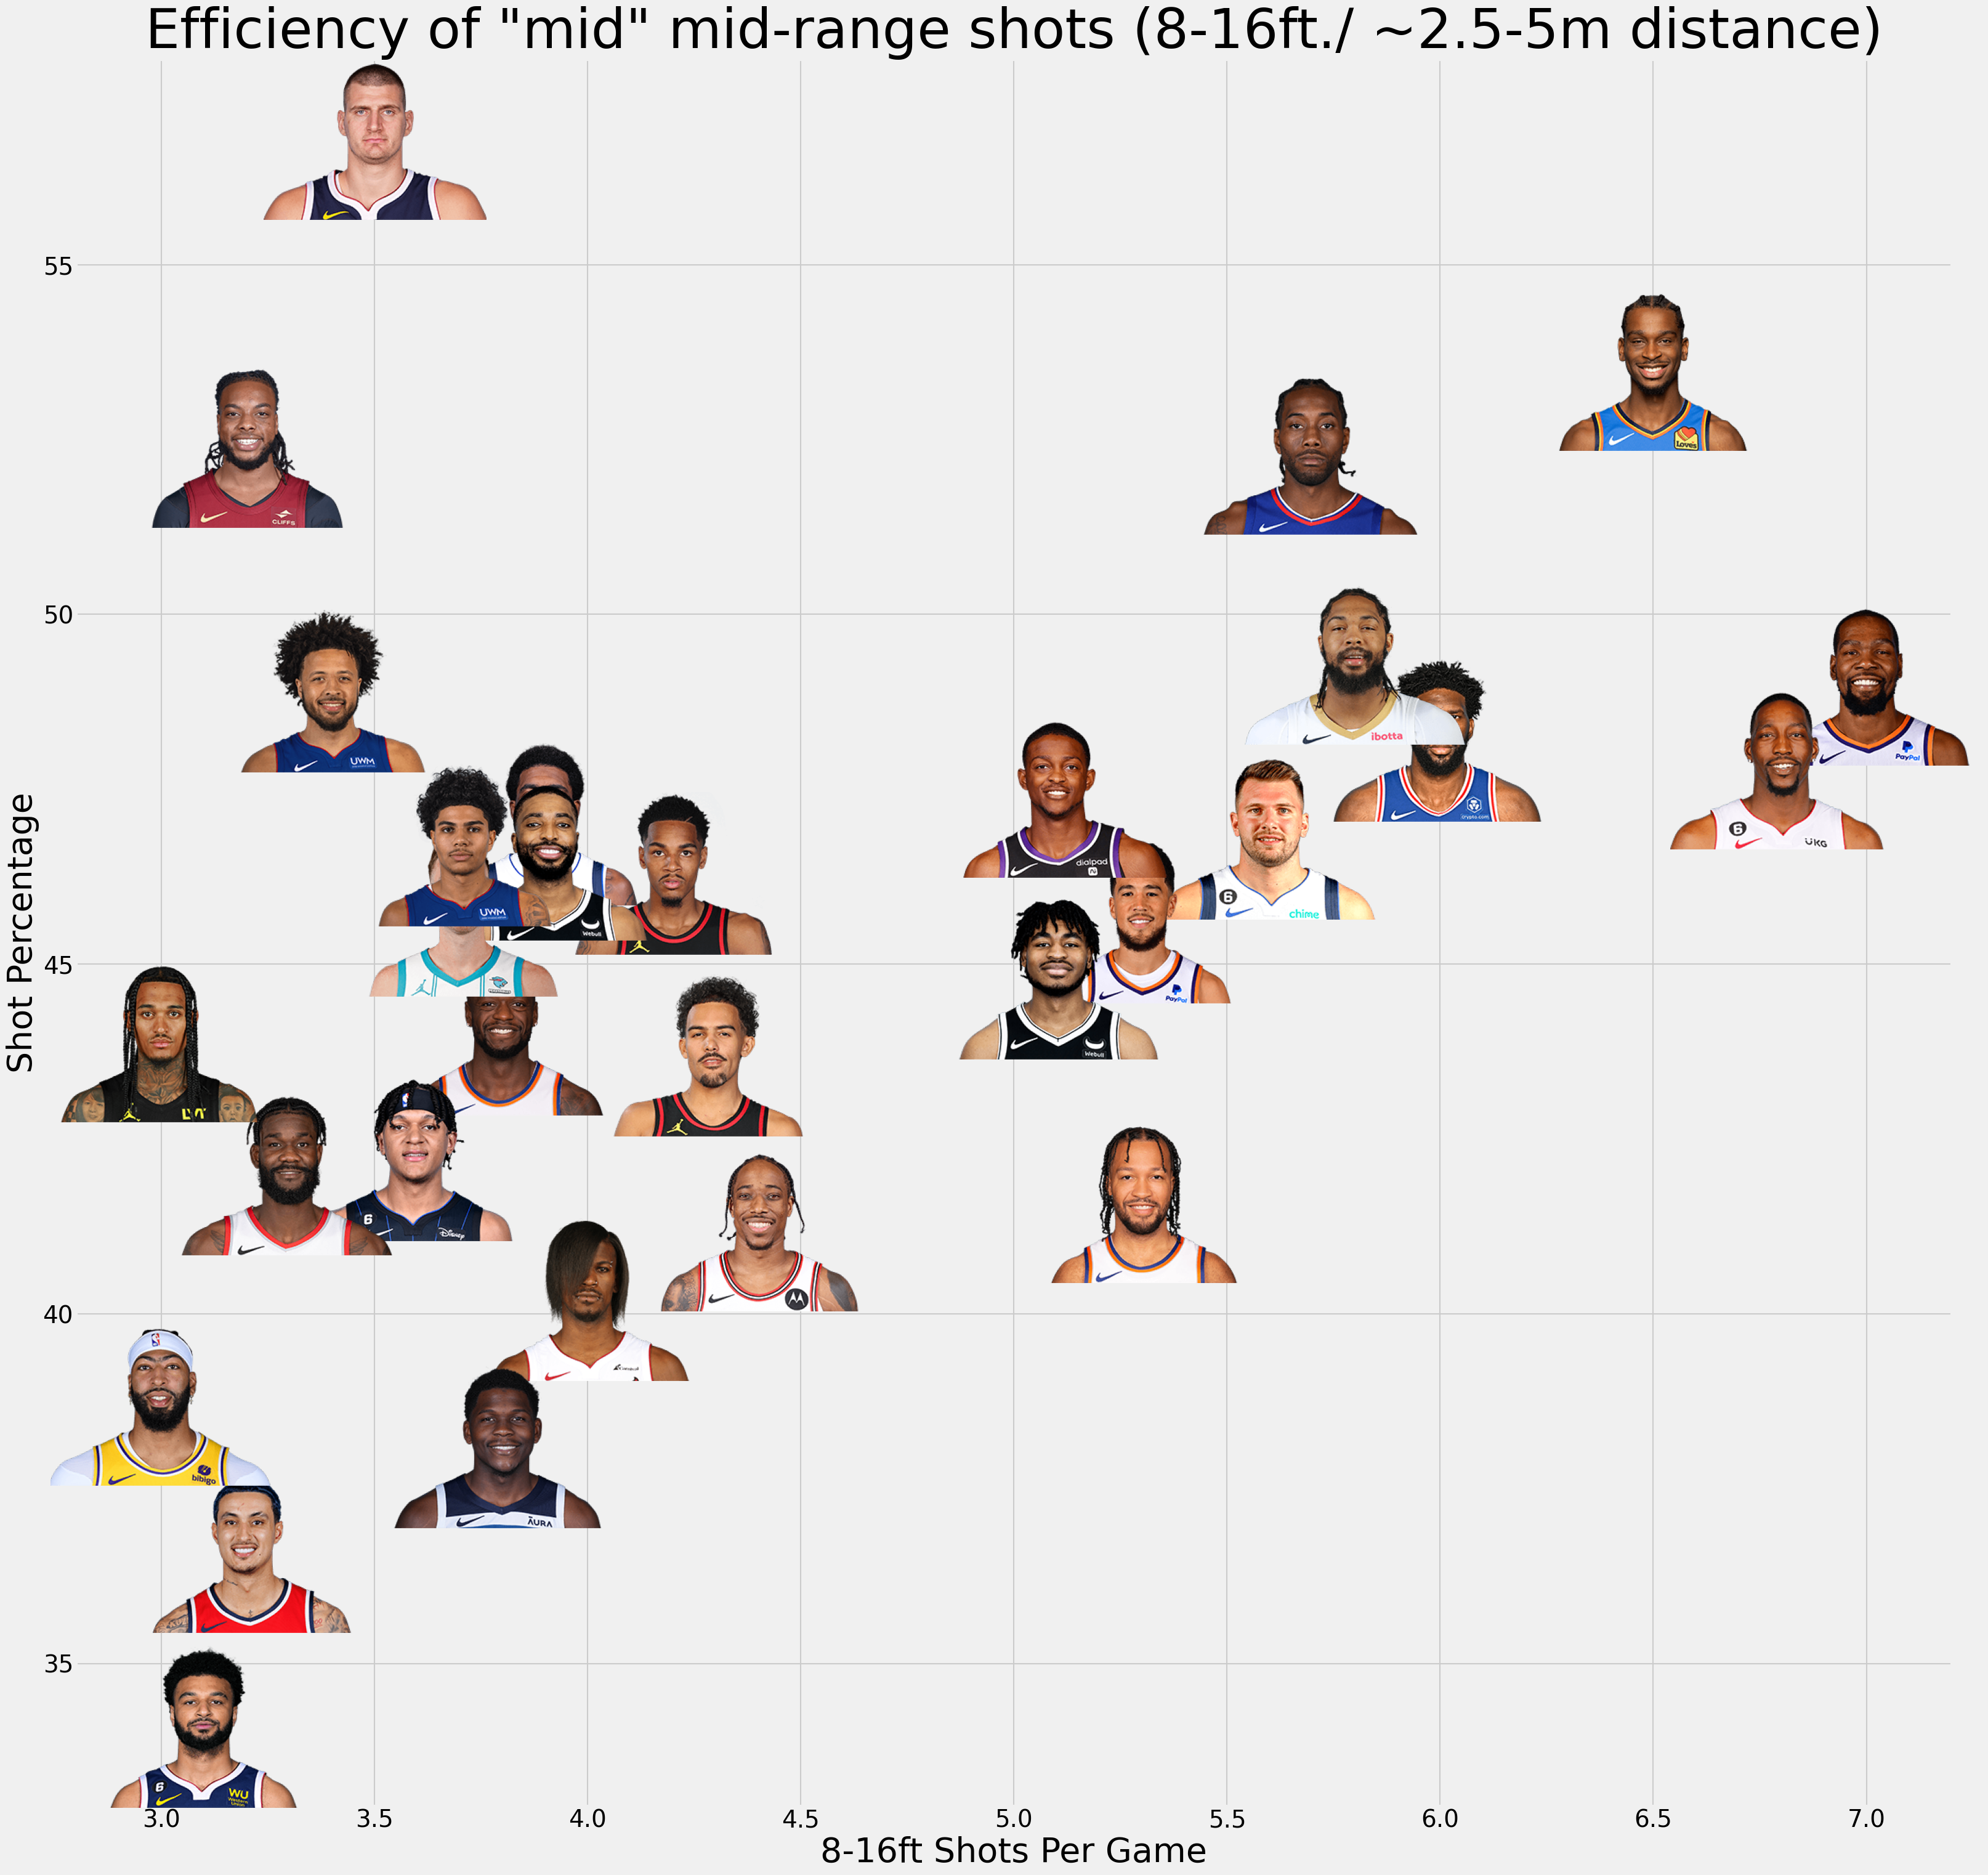

In [46]:
fig, ax = plt.subplots(figsize=(35, 35))

x=top_mid_range[('8-16 ft.','FGA')]
y=top_mid_range[('8-16 ft.','FG_PCT')]
ax.scatter(x=x, y=y, s=100)

paths = []
for i in range(len(top_mid_range)):
    item = top_mid_range.iloc[i]
    get_player_img(player_id=item[('', 'PLAYER_ID')], should_download=True)
    paths.append(f'player_imgs/{item[("", "PLAYER_ID")]}.png')

for x0, y0, path in zip(x.tolist(), y.tolist(), paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

ax.tick_params(labelsize=28)
ax.set_xlabel("8-16ft Shots Per Game", size=40)
ax.set_ylabel("Shot Percentage", size=40)
ax.set_title('Efficiency of "mid" mid-range shots (8-16ft./ ~2.5-5m distance)', size=64)


ax.grid(True, lw=1.5)